# Chapter 4
`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`

`Ported to Julia and Turing by Abid`
______

## The greatest theorem never told


This chapter focuses on an idea that is always bouncing around our minds, but is rarely made explicit outside books devoted to statistics. In fact, we've been using this simple idea in every example thus far. 

### The Law of Large Numbers

Let $Z_i$ be $N$ independent samples from some probability distribution. According to *the Law of Large numbers*,  so long as the expected value $E[Z]$ is finite, the following holds,

$$\frac{1}{N} \sum_{i=1}^N Z_i \rightarrow E[ Z ],  \;\;\; N \rightarrow \infty.$$

In words:

>   The average of a sequence of random variables from the same distribution converges to the expected value of that distribution.

This may seem like a boring result, but it will be the most useful tool you use.

### Intuition 

If the above Law is somewhat surprising,  it can be made more clear by examining a simple example. 

Consider a random variable $Z$ that can take only two values, $c_1$ and $c_2$. Suppose we have a large number of samples of $Z$, denoting a specific sample $Z_i$. The Law says that we can approximate the expected value of $Z$ by averaging over all samples. Consider the average:


$$ \frac{1}{N} \sum_{i=1}^N \;Z_i $$


By construction, $Z_i$ can only take on $c_1$ or $c_2$, hence we can partition the sum over these two values:

\begin{align}
\frac{1}{N} \sum_{i=1}^N \;Z_i
& =\frac{1}{N} \big(  \sum_{ Z_i = c_1}c_1 + \sum_{Z_i=c_2}c_2 \big) \\\\[5pt]
& = c_1 \sum_{ Z_i = c_1}\frac{1}{N} + c_2 \sum_{ Z_i = c_2}\frac{1}{N} \\\\[5pt]
& = c_1 \times \text{ (approximate frequency of $c_1$) } \\\\ 
& \;\;\;\;\;\;\;\;\; + c_2 \times \text{ (approximate frequency of $c_2$) } \\\\[5pt]
& \approx c_1 \times P(Z = c_1) + c_2 \times P(Z = c_2 ) \\\\[5pt]
& = E[Z]
\end{align}


Equality holds in the limit, but we can get closer and closer by using more and more samples in the average. This Law holds for almost *any distribution*, minus some important cases we will encounter later.

##### Example
____


Below is a diagram of the Law of Large numbers in action for three different sequences of Poisson random variables. 

 We sample `sample_size = 100000` Poisson random variables with parameter $\lambda = 4.5$. (Recall the expected value of a Poisson random variable is equal to its parameter.) We calculate the average for the first $n$ samples, for $n=1$ to `sample_size`. 

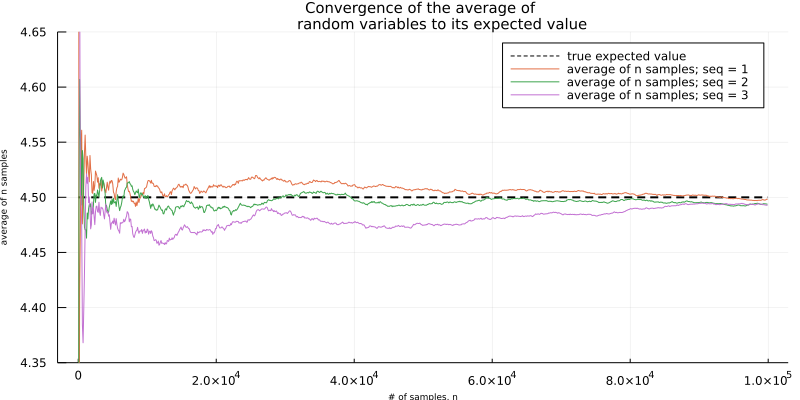

In [68]:
using Plots,Distributions

sample_size    = 100000
expected_value = lambda_ = 4.5
N_samples      = collect(1:100:sample_size)

p = plot(N_samples,expected_value.*ones(1,length(N_samples))[:],
                label = "true expected value",
                line = (:dash, 2,:black),
                xlabel = "# of samples, n",
                xguidefontsize=6,
                ylabel = "average of n samples",
                yguidefontsize=6,
                title = "Convergence of the average of 
        random variables to its expected value",
                titlefontsize = 10,
                size = (800, 400),
                ylims = (4.35,4.65),
                xticks = 0:20000:100000
)

for k in 1:3
    samples         = rand(Poisson(lambda_),sample_size)
    partial_average = [mean(samples[1:i]) for i in N_samples]
    plot!(N_samples,partial_average,label = "average of n samples; seq = $k")
end

plot(p)

Looking at the above plot, it is clear that when the sample size is small, there is greater variation in the average (compare how *jagged and jumpy* the average is initially, then *smooths* out). All three paths *approach* the value 4.5, but just flirt with it as $N$ gets large. Mathematicians and statistician have another name for *flirting*: convergence. 

Another very relevant question we can ask is *how quickly am I converging to the expected value?* Let's plot something new. For a specific $N$, let's do the above trials thousands of times and compute how far away we are from the true expected value, on average. But wait &mdash; *compute on average*? This is simply the law of large numbers again! For example, we are interested in, for a specific $N$, the quantity:

$$D(N) = \sqrt{ \;E\left[\;\; \left( \frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \;\right)^2 \;\;\right] \;\;}$$

The above formulae is interpretable as a distance away from the true value (on average), for some $N$. (We take the square root so the dimensions of the above quantity and our random variables are the same). As the above is an expected value, it can be approximated using the law of large numbers: instead of averaging $Z_i$, we calculate the following multiple times and average them:

$$ Y_k = \left( \;\frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \; \right)^2 $$

By computing the above many, $N_y$, times (remember, it is random), and averaging them:

$$ \frac{1}{N_Y} \sum_{k=1}^{N_Y} Y_k \rightarrow E[ Y_k ] = E\;\left[\;\; \left( \frac{1}{N}\sum_{i=1}^NZ_i  - 4.5 \;\right)^2 \right]$$

Finally, taking the square root:

$$ \sqrt{\frac{1}{N_Y} \sum_{k=1}^{N_Y} Y_k} \approx D(N) $$ 

In [82]:
using Statistics

N_Y         = 250 #use this many to approximate D(N)
N_array     = collect(1000:2500:50000) #use this many samples in the approx. to the variance.
D_N_results = zeros(length(N_array))

lambda_ = 4.5 
expected_value = lambda_  #for X ~ Poi(lambda) , E[ X ] = lambda

function D_N(n)
    """
    This function approx. D_n, the average variance of using n samples.
    """
    Z         = rand(Poisson(lambda_),(n,N_Y))
    average_Z = mean(Z,dims = 1)
    return sqrt(mean((average_Z .- expected_value).^2))
end

for (i,n) in enumerate(N_array)
    D_N_results[i] =  D_N(n)
end


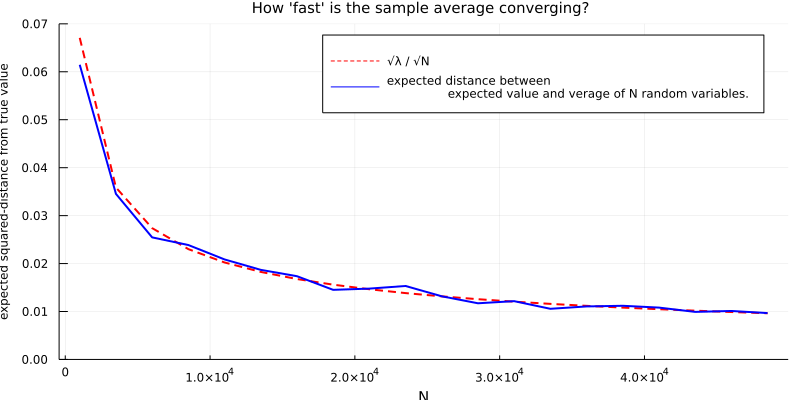

In [121]:
plot(N_array,sqrt(expected_value)./sqrt.(N_array),
                line = (:dash, 2,:red),
                label = "√λ / √N",
                xlabel = "N",
                xguidefontsize=10,
                ylabel = "expected squared-distance from true value",
                yguidefontsize=8,
                title = "How 'fast' is the sample average converging? ",
                titlefontsize = 10,
                size = (800, 400),
                xticks = 0:10000:50000,
                yticks = 0:0.01:0.08,
                ylims = (0,0.07)
                 )
plot!(N_array,D_N_results,label = "expected distance between 
                expected value and verage of N random variables.",
               lw = 2,
               color = :blue
)

As expected, the expected distance between our sample average and the actual expected value shrinks as $N$ grows large. But also notice that the *rate* of convergence decreases, that is, we need only 10 000 additional samples to move from 0.020 to 0.015, a difference of 0.005, but *20 000* more samples to again decrease from 0.015  to 0.010, again only a 0.005 decrease.


It turns out we can measure this rate of convergence. Above I have plotted a second line, the function $\sqrt{\lambda}/\sqrt{N}$. This was not chosen arbitrarily. In most cases, given a sequence of random variable distributed like $Z$, the rate of convergence to $E[Z]$ of the Law of Large Numbers is 

$$ \frac{ \sqrt{ \; Var(Z) \; } }{\sqrt{N} }$$

This is useful to know: for a given large $N$, we know (on average) how far away we are from the estimate. On the other hand, in a Bayesian setting, this can seem like a useless result: Bayesian analysis is OK with uncertainty so what's the *statistical* point of adding extra precise digits? Though drawing samples can be so computationally cheap that having a *larger* $N$ is fine too. 

### How do we compute $Var(Z)$ though?

The variance is simply another expected value that can be approximated! Consider the following, once we have the expected value (by using the Law of Large Numbers to estimate it, denote it $\mu$), we can estimate the variance:

$$ \frac{1}{N}\sum_{i=1}^N \;(Z_i - \mu)^2 \rightarrow E[ \;( Z - \mu)^2 \;] = Var( Z )$$

### Expected values and probabilities 
There is an even less explicit relationship between expected value and estimating probabilities. Define the *indicator function*

$$\mathbb{1}_A(x) = 
\begin{cases} 1 &  x \in A \\\\
              0 &  else
\end{cases}
$$
Then, by the law of large numbers, if we have many samples $X_i$, we can estimate the probability of an event $A$, denoted $P(A)$, by:

$$ \frac{1}{N} \sum_{i=1}^N \mathbb{1}_A(X_i) \rightarrow E[\mathbb{1}_A(X)] =  P(A) $$

Again, this is fairly obvious after a moments thought: the indicator function is only 1 if the event occurs, so we are summing only the times the event occurs and dividing by the total number of trials  (consider how we usually approximate probabilities using frequencies). For example, suppose we wish to estimate the probability that a $Z \sim Exp(.5)$ is greater than 5, and we have many samples from a $Exp(.5)$ distribution. 


$$ P( Z > 5 ) =  \frac{1}{N}\sum_{i=1}^N \mathbb{1}_{z > 5 }(Z_i) $$


In [135]:
N = 10000
println(mean([float(rand(Exponential(0.5)) > 5) for i in 1:N]))

0.0001


### What does this all have to do with Bayesian statistics? 


*Point estimates*, to be introduced in the next chapter, in Bayesian inference are computed using expected values. In more analytical Bayesian inference, we would have been required to evaluate complicated expected values represented as multi-dimensional integrals. No longer. If we can sample from the posterior distribution directly, we simply need to evaluate averages. Much easier. If accuracy is a priority, plots like the ones above show how fast you are converging. And if further accuracy is  desired, just take more samples from the posterior. 

When is enough enough? When can you stop drawing samples from the posterior? That is the practitioners decision, and also dependent on the variance of the samples (recall from above a high variance means the average will converge slower). 

We also should understand when the Law of Large Numbers fails. As the name implies, and comparing the graphs above for small $N$, the Law is only true for large sample sizes. Without this, the asymptotic result is not reliable. Knowing in what situations the Law fails can give us *confidence in how unconfident we should be*. The next section deals with this issue.

## The Disorder of Small Numbers

The Law of Large Numbers is only valid as $N$ gets *infinitely* large: never truly attainable.  While the law is a powerful tool, it is foolhardy to apply it liberally. Our next example illustrates this.


##### Example: Aggregated geographic data


Often data comes in aggregated form. For instance, data may be grouped by state, county, or city level. Of course, the population numbers vary per geographic area. If the data is an average of some characteristic of each the geographic areas, we must be conscious of the Law of Large Numbers and how it can *fail* for areas with small populations.

We will observe this on a toy dataset. Suppose there are five thousand counties in our dataset. Furthermore,  population number in each state are uniformly distributed between 100 and 1500. The way the population numbers are generated is irrelevant to the discussion, so we do not justify this. We are interested in measuring the average height of individuals per county. Unbeknownst to us, height does **not** vary across county, and each individual, regardless of the county he or she is currently living in, has the same distribution of what their height may be:

$$ \text{height} \sim \text{Normal}(150, 15 ) $$

We aggregate the individuals at the county level, so we only have data for the *average in the county*. What might our dataset look like?

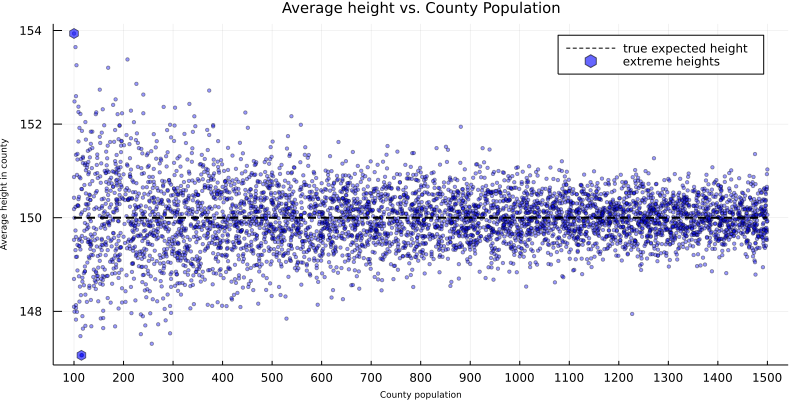

In [188]:
std_height = 15
mean_height = 150

n_counties = 5000
pop_generator = DiscreteUniform(100,1500)
norm = Normal(mean_height,std_height)

#generate some artificial population numbers
population = rand(pop_generator,n_counties)

average_across_county = zeros(n_counties)
for i in 1:n_counties
    #generate some individuals and take the mean
    average_across_county[i] = mean(rand(norm,population[i]))    
end

#located the counties with the apparently most extreme average heights.
i_min = argmin(average_across_county)
i_max = argmax(average_across_county)

scatter(population,average_across_county,
                label = nothing,
                xlabel = "County population",
                xguidefontsize=6,
                ylabel = "Average height in county",
                yguidefontsize=6,
                title = "Average height vs. County Population",
                titlefontsize = 10,
                size = (800, 400),
                xticks = 0:100:1500,marker = ( 2, 0.4, :blue)
                 )

plot!([100, 1500], [150, 150],line = (:dash, 2,:black),label = "true expected height" )

scatter!([ population[i_min], population[i_max] ], 
           [average_across_county[i_min], average_across_county[i_max] ],
           label = "extreme heights",marker = (:hexagon, 5, 0.6, :blue))


What do we observe? *Without accounting for population sizes* we run the risk of making an enormous inference error: if we ignored population size, we would say that the county with the shortest and tallest individuals have been correctly circled. But this inference is wrong for the following reason. These two counties do *not* necessarily have the most extreme heights. The error results from the calculated average of smaller populations not being a good reflection of the true expected value of the population (which in truth should be $\mu =150$). The sample size/population size/$N$, whatever you wish to call it,  is simply too small to invoke the Law of Large Numbers effectively. 

We provide more damning evidence against this inference. Recall the population numbers were uniformly distributed over 100 to 1500. Our intuition should tell us that the counties with the most extreme population heights should also be uniformly spread over 100 to 1500, and certainly independent of the county's population. Not so. Below are the population sizes of the counties with the most extreme heights.

In [194]:
println("Population sizes of 10 'shortest' counties: ")
println(population[sortperm(average_across_county)[1:10]] , '\n')
println("Population sizes of 10 'tallest' counties: ")
println(population[sortperm(average_across_county,rev = true)[1:10]])

Population sizes of 10 'shortest' counties: 
[115, 116, 257, 113, 235, 294, 118, 159, 183, 135]

Population sizes of 10 'tallest' counties: 
[100, 103, 208, 105, 169, 226, 152, 373, 240, 104]


Not at all uniform over 100 to 1500. This is an absolute failure of the Law of Large Numbers. 

##### Example:  Kaggle's *U.S. Census Return Rate Challenge*

Below is data from the 2010 US census, which partitions populations beyond counties to the level of block groups (which are aggregates of city blocks or equivalents). The dataset is from a Kaggle machine learning competition some colleagues and I participated in. The objective was to predict the census letter mail-back rate of a group block, measured between 0 and 100, using census variables (median income, number of females in the block-group, number of trailer parks, average number of children etc.). Below we plot the census mail-back rate versus block group population:

In [220]:
using CSV , DataFrames

data = DataFrame(CSV.File("data/census_data.csv"))
    
p = scatter(data[:,2] ,data[:,1],
                label = nothing,
                xlabel = "population of block-group",
                xguidefontsize=8,
                ylabel = "Mail-back rate",
                yguidefontsize=6,
                title = "Census mail-back rate vs Population",
                titlefontsize = 10,
                size = (800, 500),
                xlims = (-100,15000) ,
                xticks = 0:2000:14000,
                ylims = (-5,105) ,
                yticks = 0:20:100,
                marker = ( 1, 0.2, :green))

i_min = argmin(data[:,1])
i_max = argmax(data[:,1])

scatter!([ data[i_min,2], data[i_max,2] ], 
           [data[i_min,1], data[i_max,1] ],
           label = "most extreme points",marker = (:hexagon, 5, 0.6, :blue))

plot(p)
